In [1]:
import pandas as pd
import os
from datetime import datetime
import pvlib
from pvlib.forecast import HRRR

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()
    
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

/usr/local/lib/python3.8/dist-packages/pvlib/forecast.py:20: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  warnings.warn(


In [2]:
def getFileList(srch_dir):
    '''this function finds all files in a given directory
    '''
    
    file_list = []
    for root, directories, filenames in os.walk(srch_dir):
        for filename in filenames: 
            if filename.lower()[-4:]=='.csv':
                file_list.append(os.path.join(root,filename) )
    return file_list


def generateUnixTime(row):
    '''
        function to convert string timestamp and daylist savings flag to unix time
        
        attempts to process the two datetime string formats found in the current dataset
        but will fail if any other datetime string format is present
    '''
    
    try:
        dt = datetime.strptime(row['Time'], "%m/%d/%Y %H:%M")
    except:
        try:
           dt = datetime.strptime(row['Time'], "%Y-%m-%d %H:%M")
        except:
            print('datetime conversion failed')
            print(row['Time'])
            dt = 0
    
    dt = (dt - datetime(1970,1,1)).total_seconds()
    
    # add time diff depending on DST flag
    if row['Daylight Savings Flag'] == 'Y':
        dt += 7*60*60
    elif row['Daylight Savings Flag'] == 'N':
        dt += 8*60*60
    else:
        print('missing DST flag')
    
    return dt


def extractLoadForYear(inFolder):
    '''
        function finds all csv files in given folder, reads them as panda dfs and combines them
        converts timestamp to unix time, then drops unnecessary columns
        
        preseves unix time and original timestamp and DST flag
        
        aggregates all submeters into single total load amount
        
    '''
    

    # look in directory for load files
    fileList = getFileList(inFolder)

    # intialize dataframe var
    results = None

    # loop through found files
    for ff in fileList:
        
        print('reading: %s' %ff)
        
        # read files in list to dataframe
        df = pd.read_csv(ff)
        
        
        # drop and process columns

        # add to cumulative dataframe
        if results is None:
            print('initializing df with %s' %ff)
            results = df
        else:
            print('ading data from %s' %ff)
            results = pd.concat([results, df])
            
    return results


def processLoadData(inFolder):

    # extract and combine load data from files in inFolder
    results = extractLoadForYear(inFolder)

    # generate unix timestamp
    # this operation seems pretty inefficient, but not sure of a better way
    # since unix time requires multiple fields to calaculate
    results['unixTime'] = results.apply(generateUnixTime, axis=1)
    
    # copy to results raw, to extract datetime
    resultsRaw = results.copy(deep=True)
    resultsRaw = resultsRaw[['unixTime', 'Time', 'Daylight Savings Flag']]
    resultsRaw.columns = ['timestamp', 'datetime', 'dst']
    
    # drop rows and sum by timestamp
    results = results[['unixTime', 'Usage Value']]
    results = results.groupby(['unixTime'], as_index=False)['Usage Value'].sum()
    
    # convert timestep energy to power
    results.columns = ['timestamp', 'load']
    results.load = results.load * 4
    
    # add timestamp back to results df
    rRight = results.set_index('timestamp')

    rLeft = resultsRaw.drop_duplicates(subset=['timestamp'])
    rLeft = rLeft.set_index('timestamp')

    r2 = rRight.join(rLeft, how='left')
 
    return r2

def processLoadDataMeter(inFolder):

    # extract and combine load data from files in inFolder
    results = extractLoadForYear(inFolder)

    # generate unix timestamp
    # this operation seems pretty inefficient, but not sure of a better way
    # since unix time requires multiple fields to calaculate
    results['unixTime'] = results.apply(generateUnixTime, axis=1)
    
    # select and rename relevant columns
    results = results[['unixTime', 'Time', 'Daylight Savings Flag', 'Meter Badge Number', 'Usage Value']]
    results.columns = ['timestamp', 'datetime', 'dst', 'meter', 'load']
    # convert timestep energy to power
    results.load = results.load * 4
    
    # copy to results raw, to extract and reapply datetime/dst flag
    resultsRaw = results.copy(deep=True)
    resultsRaw = resultsRaw[['timestamp', 'datetime', 'dst']]
    
    # pivot results to make meter loads columns
    results = results[results.load!=0]
    results.reset_index(inplace=True)
    results = results[['timestamp', 'meter', 'load']]
    results = results.pivot(index='timestamp', columns='meter')

    results.columns = results.columns.droplevel(0) #remove load multiIndex
    results.columns.name = None               #remove categories
    results = results.reset_index()                #index to columns


    
    # add timestamp back to results df
    rRight = results.set_index('timestamp')

    rLeft = resultsRaw.drop_duplicates(subset=['timestamp'])
    rLeft = rLeft.set_index('timestamp')

    r2 = rRight.join(rLeft, how='left')
 
    return r2


def combineWeather(leftData, rightData):
    '''
        function combines load data and weather data by matching closest unix timestamp
        returns data for time index of leftData
    '''
    
    # sort both by index
    leftData = leftData.sort_index()
    rightData = rightData.sort_index()
    
    # convert both indices to int
    leftData.index = leftData.index.astype(int)
    rightData.index = rightData.index.astype(int)
    
    combinedData = pd.merge_asof(leftData, rightData, on="timestamp")
    
    # add solar
    load = combinedData.copy(deep=True)
    load.index = pd.to_datetime(load['timestamp'].values, unit='s', utc=True) - pd.DateOffset(minutes=15)
    load = load.tz_convert('Etc/GMT+8').tz_localize(None)
    forecast = load.copy(deep=True)
    forecast = forecast.rename(columns={'temperature': 'temp_air', 'cloudCover': 'total_clouds'})
    forecast['total_clouds'] *= 100 # scale to %
    forecast['temp_air'] += 273.15 # scale to K
    forecast = forecast.tz_localize('Etc/GMT+8')

    dummy_forecast_cols = ['wind_speed_u', 'wind_speed_v',
                           'Low_cloud_cover_low_cloud', 'Medium_cloud_cover_middle_cloud', 'High_cloud_cover_high_cloud',
                           'Pressure_surface', 'Wind_speed_gust_surface']
    for c in dummy_forecast_cols:
        forecast[c] = 0

    # process data
    forecaster = HRRR()
    forecaster.set_location(forecast.index[0].tz, 37.715434, -121.908488)
    #         self.forecast.index = self.forecast.index.tz_localize(self.tz)
    # duplicate last beacuse of bug in pvlib
    forecast.loc[forecast.index[-1]+pd.DateOffset(hours=1), :] = forecast.iloc[-1]
    data = forecaster.process_data(forecast)
    data = data.loc[forecast.index[:-1]]
    data.index = data.index.tz_localize(None)
    
    return pd.concat([load, data], axis=1)



In [3]:
# extract weather data from files
w19 = pd.read_csv(os.path.join(root, 'weather data', 'Camp Parks 2019 weather data.csv'))
w20 = pd.read_csv(os.path.join(root, 'weather data', 'Camp Parks 2020 weather data.csv'))

# set timestamp as index
w19 = w19.set_index('timestamp')
w20 = w20.set_index('timestamp')

# define directories for 2019 and 2020 data
dir2019 = os.path.join(root, 'load data', '2019')
dir2020 = os.path.join(root, 'load data', '2019')

# process load data for 2019
# r19 = processLoadData(dir2019)

# proces load data for 2020
# r20 = processLoadData(dir2020)

In [4]:
# # create weather-load tables for 2019 and 2020 for 15min and 1hr timesteps
# # then write to file
# c19 = combineWeather(r19, w19)
# print(c19.shape)
# c19.to_csv('/Users/nxd/Downloads/Parks Data/training data/Parks_2019_training_data_15min.csv')

# c19b = combineWeather(w19, r19)
# print(c19b.shape)
# c19b.to_csv('/Users/nxd/Downloads/Parks Data/training data/Parks_2019_training_data_1hr.csv')

# c20 = combineWeather(r20, w20)
# print(c20.shape)
# c20.to_csv('/Users/nxd/Downloads/Parks Data/training data/Parks_2020_training_data_15min.csv')

# c20b = combineWeather(w20, r20)
# print(c20b.shape)
# c20b.to_csv('/Users/nxd/Downloads/Parks Data/training data/Parks_2020_training_data_1hr.csv')


In [5]:
# code to generate meter-specific load training data
m19 = processLoadDataMeter(dir2019)
m20 = processLoadDataMeter(dir2020)

# create weather-load tables for 2019 and 2020 for 15min and 1hr timesteps
# then write to file
c19 = combineWeather(m19, w19)
print(c19.shape)
c19.to_csv(os.path.join(root, 'training data', 'Parks_2019_training_data_METER_15min.csv'))

# c19b = combineWeather(w19, m19)
# print(c19b.shape)
# c19b.to_csv(os.path.join(root, 'training data', 'Parks_2019_training_data_METER_1hr.csv'))
c19.resample('1H').mean(numeric_only=True).to_csv(os.path.join(root, 'training data', 'Parks_2019_training_data_METER_1hr.csv'))

c20 = combineWeather(m20, w20)
print(c20.shape)
c20.to_csv(os.path.join(root, 'training data', 'Parks_2020_training_data_METER_15min.csv'))

# c20b = combineWeather(w20, m20)
# print(c20b.shape)
# c20b.to_csv(os.path.join(root, 'training data', 'Parks_2020_training_data_METER_1hr.csv'))
c20.resample('1H').mean(numeric_only=True).to_csv(os.path.join(root, 'training data', 'Parks_2020_training_data_METER_15min.csv'))

reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190101-20190131.csv
initializing df with /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190101-20190131.csv
reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190201-20190228.csv
ading data from /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190201-20190228.csv
reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190301-20190331.csv
ading data from /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Histo

/tmp/ipykernel_4435/3035366622.py:193: pvlibDeprecationWarning: The HRRR class was deprecated in pvlib 0.9.1 and will be removed in a future release. For details, see https://pvlib-python.readthedocs.io/en/stable/user_guide/forecasts.html
  forecaster = HRRR()


(35040, 43)


/tmp/ipykernel_4435/3035366622.py:193: pvlibDeprecationWarning: The HRRR class was deprecated in pvlib 0.9.1 and will be removed in a future release. For details, see https://pvlib-python.readthedocs.io/en/stable/user_guide/forecasts.html
  forecaster = HRRR()


(35040, 43)


In [6]:
# extract raw data to explore meter-level completeness
rawData2019 = extractLoadForYear(dir2019)
rawData2020 = extractLoadForYear(dir2020)

reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190101-20190131.csv
initializing df with /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190101-20190131.csv
reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190201-20190228.csv
ading data from /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190201-20190228.csv
reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190301-20190331.csv
ading data from /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Histo

In [7]:
rawData2019.groupby('Meter Badge Number')['Usage Value'].agg(['count', 'sum'])

,count,sum
Meter Badge Number,,
1004578059,70080,5.408226e+06
1006706934,35040,1.752400e+05
1006715799,35040,4.886148e+04
1006716429,35040,1.870230e+05
1006727093,35040,4.746609e+05
1006727361,35040,5.866292e+04
1008913626,35040,4.938008e+03
1009074083,35040,2.518137e+03
1009511425,35040,4.046645e+05


In [8]:
rawData2020.groupby('Meter Badge Number')['Usage Value'].agg(['count', 'sum'])

,count,sum
Meter Badge Number,,
1004578059,70080,5.408226e+06
1006706934,35040,1.752400e+05
1006715799,35040,4.886148e+04
1006716429,35040,1.870230e+05
1006727093,35040,4.746609e+05
1006727361,35040,5.866292e+04
1008913626,35040,4.938008e+03
1009074083,35040,2.518137e+03
1009511425,35040,4.046645e+05


In [9]:
x = processLoadDataMeter(dir2019)
# x2 = x.copy(deep=True)
x.head()

reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190101-20190131.csv
initializing df with /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190101-20190131.csv
reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190201-20190228.csv
ading data from /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190201-20190228.csv
reading: /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Historical_20190301-20190331.csv
ading data from /home/Christoph/Documents/PrivateRepos/ESTCP-Controller/controller/forecaster/resources/Camp Parks Data/load data/2019/Parks_Histo

,1004578059,1006706934,1006715799,1006716429,1006727093,1006727361,1008913626,1009074083,1009511425,1009540871,1009984043,1009984060,1010054507,1010086328,1010249061,1010282897,1010397607,1010409824,datetime,dst
timestamp,,,,,,,,,,,,,,,,,,,,
1.546330e+09,558.0,18.56,5.44,33.60,33.28,0.96,0.796,0.2376,26.88,8.16,3.244,22.348,8.96,76.48,22.8,NaN,NaN,24.96,1/1/2019 0:15,N
1.546331e+09,552.6,18.56,4.80,33.28,32.64,0.64,0.792,0.8652,22.40,8.16,3.988,21.956,9.92,76.48,31.2,NaN,NaN,33.92,1/1/2019 0:30,N
1.546332e+09,549.6,18.24,4.80,33.28,31.36,1.28,0.800,0.9020,24.32,9.12,3.124,22.076,10.24,72.32,27.6,NaN,NaN,28.80,1/1/2019 0:45,N
1.546333e+09,562.2,18.56,4.80,33.28,32.64,1.28,0.796,0.3804,23.68,8.64,3.292,23.784,10.24,71.68,25.2,NaN,NaN,24.96,1/1/2019 1:00,N
1.546334e+09,549.6,18.24,5.12,33.28,35.20,0.96,0.792,0.7524,23.68,8.64,3.964,24.944,9.28,72.64,32.4,NaN,NaN,32.64,1/1/2019 1:15,N


In [10]:
x.shape

(35040, 20)

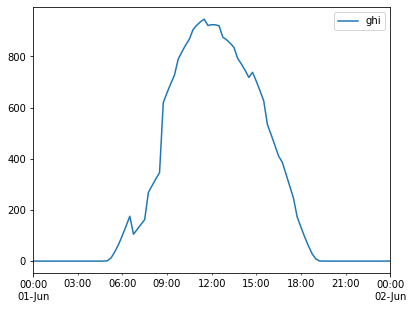

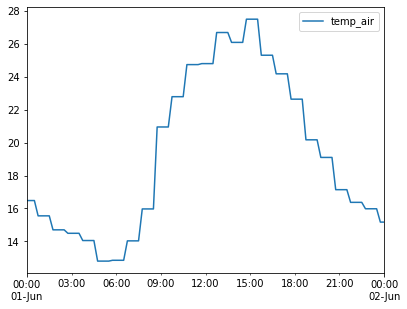

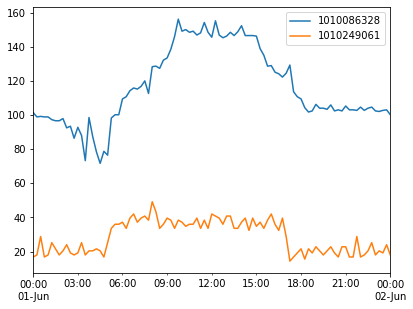

In [11]:
c19[['ghi']].loc['2019-06-01 00:00':'2019-06-02 00:00'].plot()
c19[['temp_air']].loc['2019-06-01 00:00':'2019-06-02 00:00'].plot()
c19[[1010086328, 1010249061]].loc['2019-06-01 00:00':'2019-06-02 00:00'].plot()
plt.show()

In [12]:
x2 = x.copy(deep=True)
x2 = x2[x2['load']!=0]
x2.reset_index(inplace=True)
x2 = x2[['timestamp', 'meter', 'load']]
x2 = x2.pivot(index='timestamp', columns='meter')

x2.columns = x2.columns.droplevel(0) #remove load multiIndex
x2.columns.name = None               #remove categories
x2 = x2.reset_index()                #index to columns

# print(x.shape)
print(x2.shape)

x2.head()


KeyError: 'load'

In [ ]:
x2.columns = x2.columns.droplevel(0) #remove amount
x2.columns.name = None               #remove categories
x2 = x2.reset_index()                #index to columns
x2.head()